In [9]:
import sys
import warnings
import math as m
import numpy as np
import pandas as pd
import tensorly as tl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import acf

import scipy
from scipy.linalg import hankel
from scipy.signal import find_peaks
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 
from visuals import SSA, plot_phase_trajectory

In [10]:
plt.rcParams['font.family'] = 'DejaVu Serif'

In [11]:
def delay_embedding_matrix(s, nlags, fit_intercept=False):
    """Make a matrix with delay embeddings.

    Parameters
    ----------
    s : np.array
        The time series data.

    nlags : int
        Size of time lags.

    Returns
    -------
    delay_embedding_matrix : np.array of shape  (len(s) - lags + 1 , lags)
        Matrix with lags.
    """ 
    N = len(s)
    delay_embedding_matrix = hankel(s[ : N - nlags + 1], s[N - nlags : N])
    if fit_intercept:
        delay_embedding_matrix = np.hstack((np.ones((delay_embedding_matrix.shape[0],1)),delay_embedding_matrix))
    return delay_embedding_matrix

def diag_mean(array):
    array = array[::-1]
    ts = [array.diagonal(j).mean() for j in range(-array.shape[0]+1, array.shape[1])]
    return ts

def prepare_time_series(path, centred = True):
    data = pd.read_csv(path, delimiter =';', decimal=',')
    
    time_series = data[['X_value', 'Y_value', 'Z_value']]
    time_series[['x axis', 'y axis', 'z axis']] = time_series[['X_value', 'Y_value', 'Z_value']]
    time_series = time_series[['x axis', 'y axis', 'z axis']]
    if centred:
        time_series = (time_series - np.mean(time_series, axis = 0))/np.std(time_series, axis = 0)
        
    time_points = (data['time'].values).astype(float).reshape([-1,])
    time_points = np.linspace(0,time_points[-1]-time_points[0],time_series.shape[0])

    return time_series,time_points

In [12]:
person = 'jog_16'

In [13]:
pdf_data_all = pd.read_csv(f'./../data/A_DeviceMotion_data/{person}/sub_1.csv').loc[::].reset_index(drop=True)
mean = pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']].mean()
var = pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']].var()**.5
pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']] = (pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]-mean)/var

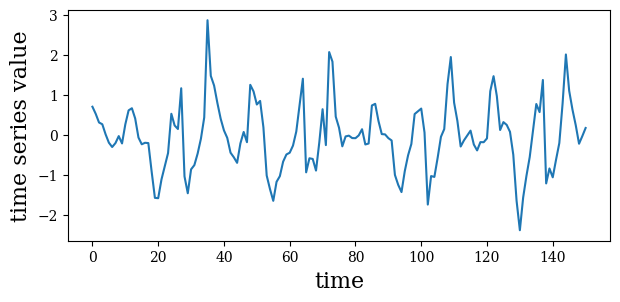

In [14]:
ax = plt.figure(figsize=(7,3)).add_subplot()
ax.plot(pdf_data_all.loc[:150, 'userAcceleration.x'])
ax.set_xlabel('time', fontsize = 16)
ax.set_ylabel('time series value', fontsize = 16)
# ax.set_title('X axis', fontsize = 24)
plt.savefig(f'./figs/{person}_sub_1_x_axis.png', format='png', dpi=150, bbox_inches='tight')

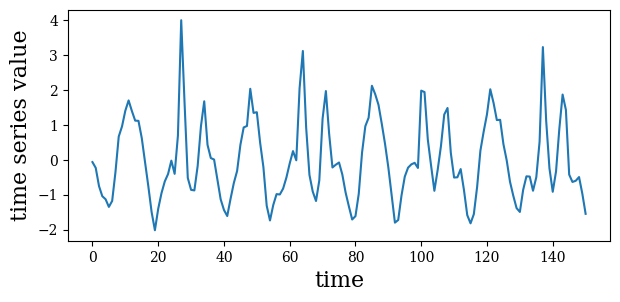

In [15]:
ax = plt.figure(figsize=(7,3)).add_subplot()
ax.plot(pdf_data_all.loc[:150, 'userAcceleration.y'])
ax.set_xlabel('time', fontsize = 16)
ax.set_ylabel('time series value', fontsize = 16)
# ax.set_title('Y axis', fontsize = 24)
plt.savefig(f'./figs/{person}_sub_1_y_axis.png', format='png', dpi=150, bbox_inches='tight')

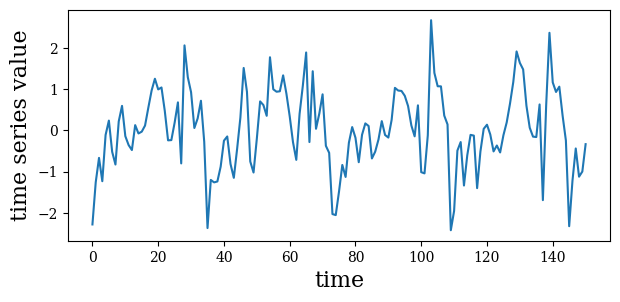

In [16]:
ax = plt.figure(figsize=(7,3)).add_subplot()
ax.plot(pdf_data_all.loc[:150, 'userAcceleration.z'])
ax.set_xlabel('time', fontsize = 16)
ax.set_ylabel('time series value', fontsize = 16)
# ax.set_title('Z axis', fontsize = 24)
plt.savefig(f'./figs/{person}_sub_1_z_axis.png', format='png', dpi=150, bbox_inches='tight')

In [17]:
dim_n = 3
lag = 50

############### Forecasting component ####################################################
Z = delay_embedding_matrix(pdf_data_all['userAcceleration.z'].to_numpy(), lag)

##########################################################################################                         
S = np.array([
    delay_embedding_matrix(pdf_data_all['userAcceleration.x'].to_numpy(), lag),
    delay_embedding_matrix(pdf_data_all['userAcceleration.y'].to_numpy(), lag)
])

S_tens = np.array([tl.tenalg.outer([S[n,i_,:] for n in range(S.shape[0])]).reshape(-1,) for i_ in range(S.shape[1])])

to_root = pdf_data_all[['userAcceleration.x', 'userAcceleration.y']].copy()+10
s_root = (to_root['userAcceleration.x'].to_numpy()**2 + to_root['userAcceleration.y'].to_numpy()**2)**.5
s_root = (s_root - s_root.mean())/s_root.var()
S_root = delay_embedding_matrix(s_root, lag)


############### Simple PCA for X #########################################################
Xx = PCA(n_components=dim_n).fit_transform(delay_embedding_matrix(pdf_data_all['userAcceleration.x'].to_numpy(), lag))

############### Simple PCA for X #########################################################
Xy = PCA(n_components=dim_n).fit_transform(delay_embedding_matrix(pdf_data_all['userAcceleration.y'].to_numpy(), lag))

############### PCA for X #########################################################
X_root = PCA(n_components=dim_n).fit_transform(S_root)

############### Tensor XY and PCA ########################################################
X_tens = PCA(n_components=dim_n).fit_transform(S_tens)

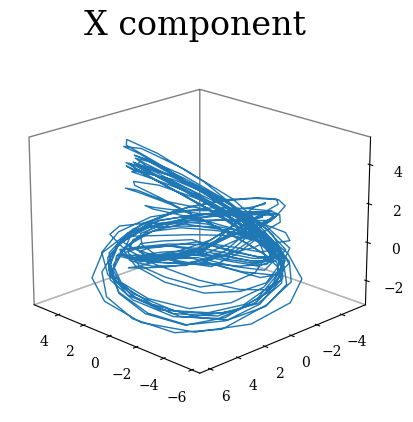

In [18]:
ax = plot_phase_trajectory(phase_trajectory = Xx[:500,:])
ax.set_title('X component', fontsize = 24)
plt.savefig(f'./figs/{person}_sub_1_x_attractor.png', format='png', dpi=100, bbox_inches='tight')

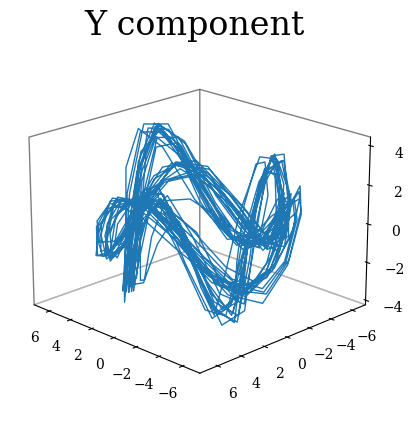

In [19]:
ax = plot_phase_trajectory(phase_trajectory = Xy[:500,:])
ax.set_title('Y component', fontsize = 24)
plt.savefig(f'./figs/{person}_sub_1_y_attractor.png', format='png', dpi=100, bbox_inches='tight')

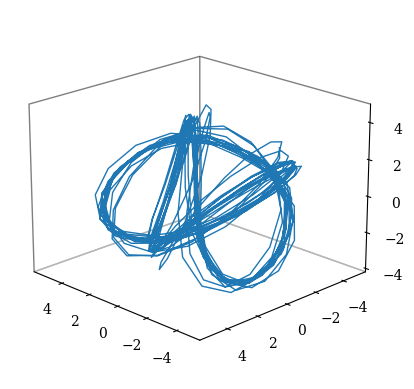

In [20]:
ax = plot_phase_trajectory(phase_trajectory = X_root[:500,:])
# ax.set_title('Squared sum\nX and Y components', fontsize = 24)
plt.savefig(f'./figs/{person}_sub_1_squared_sum_attractor.png', format='png', dpi=100, bbox_inches='tight')

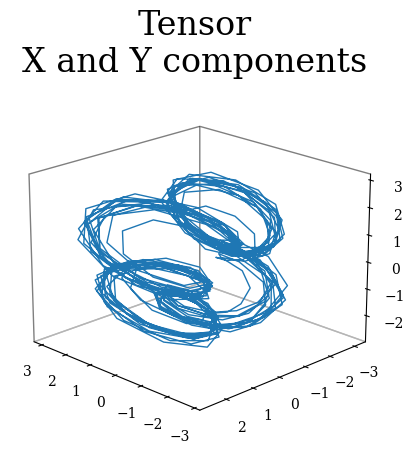

In [21]:
ax = plot_phase_trajectory(phase_trajectory = X_tens[:500,:]/10, rotation= (-115,0,0))
ax.set_title('Tensor\nX and Y components', fontsize = 24)
plt.savefig(f'./figs/{person}_sub_1_tensor_attractor.png', format='png', dpi=100, bbox_inches='tight')

In [22]:
dim_n = 10
############### Simple PCA for X #########################################################
Xx = PCA(n_components=dim_n).fit_transform(delay_embedding_matrix(pdf_data_all['userAcceleration.x'].to_numpy(), lag))
############### Simple PCA for X #########################################################
Xy = PCA(n_components=dim_n).fit_transform(delay_embedding_matrix(pdf_data_all['userAcceleration.y'].to_numpy(), lag))
############### PCA for X #########################################################
X_root = PCA(n_components=dim_n).fit_transform(S_root)
############### Tensor XY and PCA ########################################################
X_tens = PCA(n_components=dim_n).fit_transform(S_tens)

In [23]:
l2_coef = 0.1
Wx = (np.linalg.inv(Xx.T@Xx + l2_coef*np.identity(dim_n))@Xx.T@Z)
Wy = (np.linalg.inv(Xy.T@Xy + l2_coef*np.identity(dim_n))@Xy.T@Z)
W_root = (np.linalg.inv(X_root.T@X_root + l2_coef*np.identity(dim_n))@X_root.T@Z)
W_tens = (np.linalg.inv(X_tens.T@X_tens + l2_coef*np.identity(dim_n))@X_tens.T@Z)

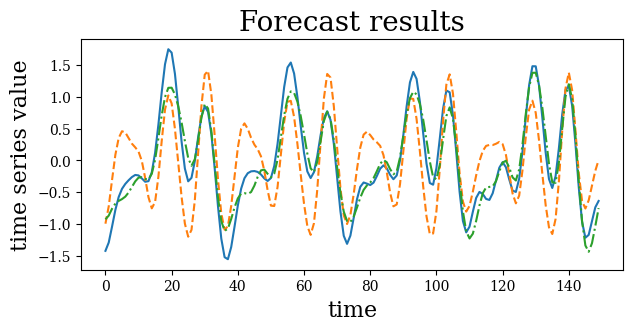

In [25]:
ax = plt.figure(figsize=(7,3)).add_subplot()
ax.plot(diag_mean(Xx@Wx)[:150], label = 'Simple PCA for X axis')
ax.plot(diag_mean(X_root@W_root)[:150], '--',label = 'Sum of squares\nfor X,Y components')
ax.plot(diag_mean(X_tens@W_tens)[:150], linestyle = 'dashdot', label = 'Tensor approach\nfor X,Y components')
ax.set_xlabel('time', fontsize = 16)
ax.set_ylabel('time series value', fontsize = 16)
ax.set_title('Forecast results', fontsize = 20)
# ax.legend(fontsize = 12, loc='upper center', bbox_to_anchor=(0.78, 1.))
plt.savefig(f'./figs/{person}_reconctructed_z_axis.png', format='png', dpi=150, bbox_inches='tight')

In [36]:
def main(activity):
    pdf_result_r2 = pd.DataFrame(columns=['Simple PCA for X axis','Simple PCA for Y axis', 'Sum of squares for X,Y components','Tensor approach for X,Y components'])
    pdf_result_mse = pd.DataFrame(columns=['Simple PCA for X axis','Simple PCA for Y axis', 'Sum of squares for X,Y components','Tensor approach for X,Y components'])
    pdf_result_mape = pd.DataFrame(columns=['Simple PCA for X axis','Simple PCA for Y axis', 'Sum of squares for X,Y components','Tensor approach for X,Y components'])
    
    for person in tqdm(np.arange(1,6)):
        _pdf_result_r2 = pd.DataFrame(columns=['Simple PCA for X axis','Simple PCA for Y axis', 'Sum of squares for X,Y components','Tensor approach for X,Y components'])
        _pdf_result_mse = pd.DataFrame(columns=['Simple PCA for X axis','Simple PCA for Y axis', 'Sum of squares for X,Y components','Tensor approach for X,Y components'])
        _pdf_result_mape = pd.DataFrame(columns=['Simple PCA for X axis','Simple PCA for Y axis', 'Sum of squares for X,Y components','Tensor approach for X,Y components'])
        
        freq_n = 1
        lag = 70
        l2_coef = 0.1
        pdf_data_all = pd.read_csv(f'./../data/A_DeviceMotion_data/{activity}/sub_{person}.csv').loc[::freq_n].reset_index(drop=True)
        mean = pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']].mean()
        var = pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']].var()**.5
        pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']] = (pdf_data_all[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']]-mean)/var
        
        ############### Forecasting component ####################################################
        Z = delay_embedding_matrix(pdf_data_all['userAcceleration.z'].to_numpy(), lag)
    
        ##########################################################################################                         
        S = np.array([
            delay_embedding_matrix(pdf_data_all['userAcceleration.x'].to_numpy(), lag, fit_intercept=True),
            delay_embedding_matrix(pdf_data_all['userAcceleration.y'].to_numpy(), lag, fit_intercept=True)
        ])
        
        S_tens = np.array([tl.tenalg.outer([S[n,i_,:] for n in range(S.shape[0])]).reshape(-1,) for i_ in range(S.shape[1])])
        
        to_root = pdf_data_all[['userAcceleration.x', 'userAcceleration.y']].copy()+10
        s_root = (to_root['userAcceleration.x'].to_numpy()**2 + to_root['userAcceleration.y'].to_numpy()**2)**.5
        s_root = (s_root - s_root.mean())/s_root.var()
        S_root = delay_embedding_matrix(s_root, lag)
        for dim_n in range(3,26):
            ############### Simple PCA for X #########################################################
            Xx = PCA(n_components=dim_n).fit_transform(delay_embedding_matrix(pdf_data_all['userAcceleration.x'].to_numpy(), lag))
            Wx = (np.linalg.inv(Xx.T@Xx + l2_coef*np.identity(dim_n))@Xx.T@Z)
            
            ############### Simple PCA for X #########################################################
            Xy = PCA(n_components=dim_n).fit_transform(delay_embedding_matrix(pdf_data_all['userAcceleration.y'].to_numpy(), lag))
            Wy = (np.linalg.inv(Xy.T@Xy + l2_coef*np.identity(dim_n))@Xy.T@Z)
    
            ############### PCA for X and Y squared sum ##############################################
            X_root = PCA(n_components=dim_n).fit_transform(S_root)
            W_root = (np.linalg.inv(X_root.T@X_root + l2_coef*np.identity(dim_n))@X_root.T@Z)
            
            ############### Tensor XY and PCA ########################################################
            X_tens = PCA(n_components=dim_n).fit_transform(S_tens)
            W_tens = (np.linalg.inv(X_tens.T@X_tens + l2_coef*np.identity(dim_n))@X_tens.T@Z)
            
            ##########################################################################################
            _pdf_result_r2.loc[dim_n, :] = [
                r2_score(diag_mean(Z), diag_mean(Xx@Wx)),
                r2_score(diag_mean(Z), diag_mean(Xy@Wy)),
                r2_score(diag_mean(Z), diag_mean(X_root@W_root)),
                r2_score(diag_mean(Z), diag_mean(X_tens@W_tens))
            ]
            pdf_result_r2 = pd.concat([pdf_result_r2, _pdf_result_r2], axis=0)
            
            pdf_result_mse.loc[dim_n, :] = [
                mse(diag_mean(Z), diag_mean(Xx@Wx))**.5,
                mse(diag_mean(Z), diag_mean(Xy@Wy))**.5,
                mse(diag_mean(Z), diag_mean(X_root@W_root))**.5,
                mse(diag_mean(Z), diag_mean(X_tens@W_tens))**.5
            ]
            _pdf_result_mse = pd.concat([pdf_result_mse, _pdf_result_mse], axis=0)
    
    pdf_result_r2 = pdf_result_r2.reset_index().groupby('index').mean()
    pdf_result_mse = pdf_result_mse.reset_index().groupby('index').mean()

    ax = pdf_result_r2.plot()
    ax.set_xlabel("Attractor dimension", fontsize = 20)
    ax.set_ylabel("R2 score", fontsize = 20)
    plt.savefig(f'./figs/_1_{activity}_r2_z_axis.png', format='png', dpi=150, bbox_inches='tight')
    
    ax = pdf_result_mse.plot()
    ax.set_xlabel("Attractor dimension", fontsize = 20)
    ax.set_ylabel("Root mean square deviation", fontsize = 20)
    plt.savefig(f'./figs/_2_{activity}_mse_z_axis.png', format='png', dpi=150, bbox_inches='tight')
    
    return pdf_result_r2, pdf_result_mse

100%|██████████| 5/5 [00:43<00:00,  8.68s/it]


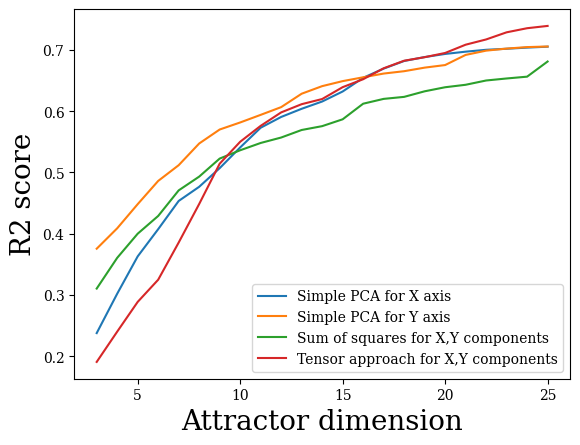

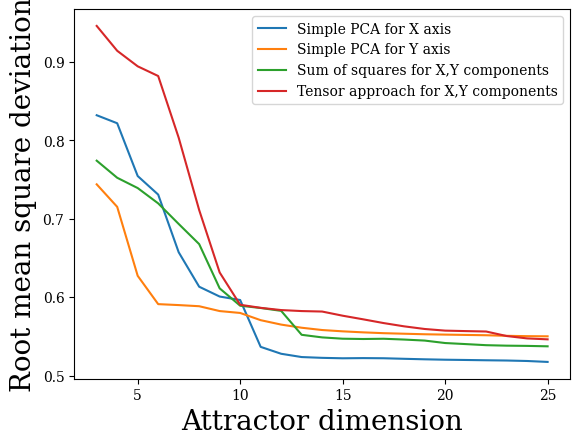

In [37]:
pdf_result_r2, pdf_result_mse = main('wlk_15')

In [38]:
pdf_to_tex_r2 = pdf_result_r2.loc[[3,7,15,20,25]]
pdf_to_tex_r2.columns = pd.MultiIndex.from_tuples([('Only X axis', 'R2'), ('Only Y axis', 'R2'),	('rSS for X,Y', 'R2'), ('Tensor X,Y', 'R2')])
pdf_to_tex_mse = pdf_result_mse.loc[[3,7,15,20,25]]
pdf_to_tex_mse.columns = pd.MultiIndex.from_tuples([('Only X axis', 'rMSE'), ('Only Y axis', 'rMSE'),	('rSS for X,Y' , 'rMSE'), ('Tensor X,Y', 'rMSE')])

pdf = pd.concat([pdf_to_tex_r2,pdf_to_tex_mse], axis = 1)
pdf = pdf.reindex(sorted(pdf.columns), axis=1)
pdf.index.names = ['Dimension']

column_format = 'l|'+'|'.join(['p{1cm}p{1cm}' for _ in range(int(pdf.shape[1]/2))])
print(pdf.astype(float).to_latex(float_format="{:.2f}".format, column_format = column_format).replace('{r}', '{p{2cm}}'))

\begin{tabular}{l|p{1cm}p{1cm}|p{1cm}p{1cm}|p{1cm}p{1cm}|p{1cm}p{1cm}}
\toprule
 & \multicolumn{2}{p{2cm}}{Only X axis} & \multicolumn{2}{p{2cm}}{Only Y axis} & \multicolumn{2}{p{2cm}}{Tensor X,Y} & \multicolumn{2}{p{2cm}}{rSS for X,Y} \\
 & R2 & rMSE & R2 & rMSE & R2 & rMSE & R2 & rMSE \\
Dimension &  &  &  &  &  &  &  &  \\
\midrule
3 & 0.24 & 0.83 & 0.38 & 0.74 & 0.19 & 0.95 & 0.31 & 0.77 \\
7 & 0.45 & 0.66 & 0.51 & 0.59 & 0.39 & 0.80 & 0.47 & 0.69 \\
15 & 0.63 & 0.52 & 0.65 & 0.56 & 0.64 & 0.58 & 0.59 & 0.55 \\
20 & 0.69 & 0.52 & 0.68 & 0.55 & 0.70 & 0.56 & 0.64 & 0.54 \\
25 & 0.71 & 0.52 & 0.71 & 0.55 & 0.74 & 0.55 & 0.68 & 0.54 \\
\bottomrule
\end{tabular}



100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


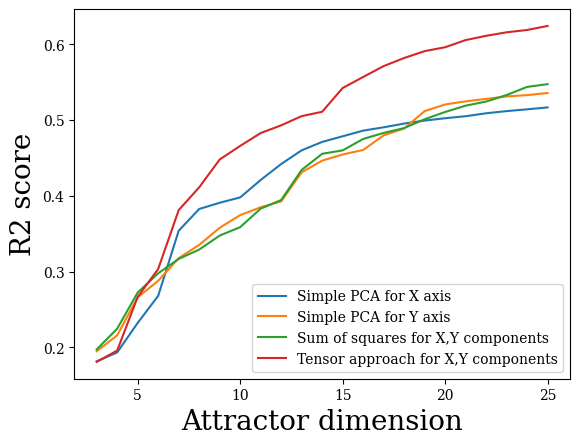

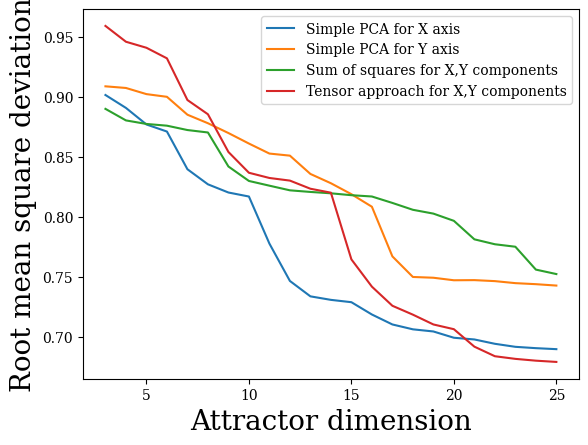

In [39]:
pdf_result_r2, pdf_result_mse = main('jog_16')

In [40]:
pdf_to_tex_r2 = pdf_result_r2.loc[[3,7,15,20,25]]
pdf_to_tex_r2.columns = pd.MultiIndex.from_tuples([('Only X axis', 'R2'), ('Only Y axis', 'R2'),	('rSS for X,Y', 'R2'), ('Tensor X,Y', 'R2')])
pdf_to_tex_mse = pdf_result_mse.loc[[3,7,15,20,25]]
pdf_to_tex_mse.columns = pd.MultiIndex.from_tuples([('Only X axis', 'rMSE'), ('Only Y axis', 'rMSE'),	('rSS for X,Y' , 'rMSE'), ('Tensor X,Y', 'rMSE')])

pdf = pd.concat([pdf_to_tex_r2,pdf_to_tex_mse], axis = 1)
pdf = pdf.reindex(sorted(pdf.columns), axis=1)
pdf.index.names = ['Dimension']

column_format = 'l|'+'|'.join(['p{1cm}p{1cm}' for _ in range(int(pdf.shape[1]/2))])
print(pdf.astype(float).to_latex(float_format="{:.2f}".format, column_format = column_format).replace('{r}', '{p{2cm}}'))

\begin{tabular}{l|p{1cm}p{1cm}|p{1cm}p{1cm}|p{1cm}p{1cm}|p{1cm}p{1cm}}
\toprule
 & \multicolumn{2}{p{2cm}}{Only X axis} & \multicolumn{2}{p{2cm}}{Only Y axis} & \multicolumn{2}{p{2cm}}{Tensor X,Y} & \multicolumn{2}{p{2cm}}{rSS for X,Y} \\
 & R2 & rMSE & R2 & rMSE & R2 & rMSE & R2 & rMSE \\
Dimension &  &  &  &  &  &  &  &  \\
\midrule
3 & 0.18 & 0.90 & 0.19 & 0.91 & 0.18 & 0.96 & 0.20 & 0.89 \\
7 & 0.35 & 0.84 & 0.32 & 0.89 & 0.38 & 0.90 & 0.32 & 0.87 \\
15 & 0.48 & 0.73 & 0.45 & 0.82 & 0.54 & 0.76 & 0.46 & 0.82 \\
20 & 0.50 & 0.70 & 0.52 & 0.75 & 0.60 & 0.71 & 0.51 & 0.80 \\
25 & 0.52 & 0.69 & 0.54 & 0.74 & 0.62 & 0.68 & 0.55 & 0.75 \\
\bottomrule
\end{tabular}

